# PFDA Project

### by E. Qejvani
***

## Introduction

This project presents two weather datasets, from Johnstown Castle and Valentia Island, for users to explore and analyze factors that could influence the decision to build a wind turbine or wind farm. Given the wide range of factors involved in such a decision—like wind speed, temperature, and other meteorological conditions—this analysis remains open-ended, allowing users to examine the data and make their own conclusions about the feasibility of installing wind turbines or a wind farm.

**A Few Words About the Rain Factor and Why I Didn't Focus on It**

When evaluating a potential wind farm location, the impact of rain and its effect on turbines, particularly regarding erosion rates, is an important consideration. According to a document I reviewed, Valentia Island has an erosion rate of 0.127% per month [Rain Erosion Maps](./files/rain-erosion-maps-for-wind-turbines.pdf), while Johnstown Castle has a lower rate of 0.055%. Although this might present challenges, it doesn't necessarily disqualify Valentia Island as a potential site for a wind farm. In fact, Valentia offers more favorable wind trends with stronger and more consistent winds, making it a promising location for wind energy. Additionally, there is an application for an offshore community wind farm in the area [Valentia Island Energy Ltd.](https://vienergy.ie/), further emphasizing its potential for wind energy generation.

However, after considering the erosion rates outlined in the document, I decided not to focus on this factor for this project. Such erosion rates would likely influence decisions made by engineers or financial specialists who would factor it into their analysis of other key considerations, such as the long-term viability of turbine performance and financial investments. Therefore, I chose to leave this aspect out of the scope of my analysis.

**Other Factors This Project Doesn't Take Into Account**

This project shows how tricky it can be to decide where to place wind turbines, as there are many different factors to consider. I focused mainly on things like wind patterns, power generation, and seasonal changes, but there are many other important factors that I didn’t look at. These include the impact on wildlife, the availability of land, how close the site is to existing power lines, and whether it could cause noise or visual problems for nearby communities. 

Other factors like the soil type, how easy it is to transport turbine parts, and the local weather conditions also matter a lot. These are things that engineers and planners would consider when deciding where to build a wind farm. I really enjoyed working through the open-ended nature of this project, even though it was sometimes hard to decide which way to go with so many different things to think about. It was a good challenge and helped me learn more about the potential for wind energy. 

***
## Part 1 - Preparing the dataset.
***

* Uploading the libraries.
* Keeping the information we are interested in.
* Preparing the dataset for analyzing.
    - Checking data types of the coulumns.
    - Checking for empty value cells or NaN value cells.
    - Cleaning the dataset.

In [44]:
# Importing the libraries.
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from scipy.stats import linregress
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing project_functions file where I'm storing all the functions to use in this project. 
from working_with_df_functions import *  
from calculation_functions import *   
from menu_code import *     

In [45]:
# Calling the function to load the dataset
df_wind_project = load_wind_dataset()
df_wind_project.head(3)

Choose a dataset to analyze:
1. Valentia dataset
2. Johnstown Castle dataset
Loading the Valentia dataset...
Dataset loaded successfully!


,date,rain,temp,vappr,msl,wdsp,wddir
0,01-jan-1945 00:00,0.0,8.9,11.3,1037.2,3,350
1,01-jan-1945 01:00,0.0,8.5,10.8,1037.2,2,360
2,01-jan-1945 02:00,0.0,8.8,10.6,1037.3,6,10


### Checking the dataset.

In [46]:
# Information about our dataset.
df_wind_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701280 entries, 0 to 701279
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    701280 non-null  object
 1   rain    701280 non-null  object
 2   temp    701280 non-null  object
 3   vappr   701280 non-null  object
 4   msl     701280 non-null  object
 5   wdsp    701280 non-null  object
 6   wddir   701280 non-null  object
dtypes: object(7)
memory usage: 37.5+ MB


### Changing the data types in my dataset.

As we can see from the above all data types in the dataset are object type. To change this I am going to:
- Change the date column type to date type data.
- Change the rest of the columns to float type data. 
- I’m converting the data type of my columns to `float32` to reduce memory usage, as my dataset is quite large.
- I’m creating a function for these changes in the `project_functions.py` file, which will also serve as a repository for all the functions used in my project.
- I am setting the `date` column as the index to make it easier to work with the data based on time, like sorting or grouping by dates.

In [47]:
# Columns_to_convert will pass to `convert_columns_to_float` function all columns that need to change to numeric data.  
columns_to_convert = ['temp','rain', 'vappr', 'msl', 'wdsp', 'wddir']
df_wind_project = convert_columns_to_float(df_wind_project, columns_to_convert)
df_wind_project['date'] = pd.to_datetime(df_wind_project['date'], format="%d-%b-%Y %H:%M", errors='coerce')
# Setting the date as index
df_wind_project.set_index('date', inplace=True)

In [48]:
# With the `.info` command I am checking that the changes took effect.
df_wind_project.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701280 entries, 1945-01-01 00:00:00 to 2025-01-01 00:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    701238 non-null  float32
 1   temp    701220 non-null  float32
 2   vappr   701220 non-null  float32
 3   msl     701220 non-null  float32
 4   wdsp    701235 non-null  float32
 5   wddir   701171 non-null  float32
dtypes: float32(6)
memory usage: 21.4 MB


In [49]:
# Displaying the first three rows to check the structure and columns again in my dataset.
df_wind_project.head(3)

,rain,temp,vappr,msl,wdsp,wddir
date,,,,,,
1945-01-01 00:00:00,0.0,8.9,11.3,1037.199951,3.0,350.0
1945-01-01 01:00:00,0.0,8.5,10.8,1037.199951,2.0,360.0
1945-01-01 02:00:00,0.0,8.8,10.6,1037.300049,6.0,10.0


### Checking for missing data, NaN values and single space values `' '`

In Assignment Six of this module, I found out that using `.isna()` and `.isnull()` alone is insufficient for cleaning the dataset. Sometimes, cells can contain an empty value represented by a single space (stored as a string). Therefore, in the next section, I will check for any cells that contain a single space as their value.

### Counting the rows that hold empty cells.

* I created a function named `count_rows_with_empty_or_space_cells_detail` in the `project_functions` file that counts all the rows that hold empty cells. 

In [50]:
# Calling the funtion from the 'project_functions.py' file.
count_rows_with_empty_or_space_cells_detail(df_wind_project)

Rows with 0 empty cells: 701104
Rows with 1 empty cells: 75
Rows with 2 empty cells: 41
Rows with 3 empty cells: 22
Rows with 4 empty cells: 37
Rows with 5 empty cells: 1
Total rows with at least one empty values: 176


176

### Cleaning the rows with empty cells.

* Because of the big size of the dataset I decided to remove all the rows that contain empty cells.
* The function `remove_rows_with_missing_data` called below drops all the rows containing empty cells.

In [51]:
# Calling remove_rows_with_missing_data function to clean/drop all the rows with empty cells.
df_wind_project = remove_rows_with_missing_data(df_wind_project)
df_wind_project.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701104 entries, 1945-01-01 00:00:00 to 2025-01-01 00:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    701104 non-null  float32
 1   temp    701104 non-null  float32
 2   vappr   701104 non-null  float32
 3   msl     701104 non-null  float32
 4   wdsp    701104 non-null  float32
 5   wddir   701104 non-null  float32
dtypes: float32(6)
memory usage: 21.4 MB


### Converting wind speed to metres per second.

To convert the wind speed (wdsp) from knots to metres per second, I will use the conversion factor of 1 knot = 0.51444 metres/second. In the dataset, wind speed is currently measured in knots, representing the speed of the wind in nautical miles per hour. For my analysis, I need the wind speed expressed in metres per second. To achieve this, I will create a new column in the df_wind_project dataset to store the wind speed values converted to metres per second.

In [52]:
# Create a new column with the windspeed in metre/second
df_wind_project['wdsp_m/s'] = (df_wind_project['wdsp'] * 0.51444).round(2)

In [53]:
df_wind_project.head()

,rain,temp,vappr,msl,wdsp,wddir,wdsp_m/s
date,,,,,,,
1945-01-01 00:00:00,0.0,8.9,11.3,1037.199951,3.0,350.0,1.54
1945-01-01 01:00:00,0.0,8.5,10.8,1037.199951,2.0,360.0,1.03
1945-01-01 02:00:00,0.0,8.8,10.6,1037.300049,6.0,10.0,3.09
1945-01-01 03:00:00,0.0,8.9,10.6,1037.500000,9.0,350.0,4.63
1945-01-01 04:00:00,0.0,9.3,10.8,1037.599976,9.0,350.0,4.63


In [54]:
# I don't need any more the wind speed column in knot so I am removing it from the dataset.
df_wind_project = df_wind_project.drop(columns=['wdsp'])
df_wind_project.head()

,rain,temp,vappr,msl,wddir,wdsp_m/s
date,,,,,,
1945-01-01 00:00:00,0.0,8.9,11.3,1037.199951,350.0,1.54
1945-01-01 01:00:00,0.0,8.5,10.8,1037.199951,360.0,1.03
1945-01-01 02:00:00,0.0,8.8,10.6,1037.300049,10.0,3.09
1945-01-01 03:00:00,0.0,8.9,10.6,1037.500000,350.0,4.63
1945-01-01 04:00:00,0.0,9.3,10.8,1037.599976,350.0,4.63


In [55]:
df_wind_project.info()
df_wind_project.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701104 entries, 1945-01-01 00:00:00 to 2025-01-01 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   rain      701104 non-null  float32
 1   temp      701104 non-null  float32
 2   vappr     701104 non-null  float32
 3   msl       701104 non-null  float32
 4   wddir     701104 non-null  float32
 5   wdsp_m/s  701104 non-null  float32
dtypes: float32(6)
memory usage: 21.4 MB


Index(['rain', 'temp', 'vappr', 'msl', 'wddir', 'wdsp_m/s'], dtype='object')

***
## Part 2: Analysing Data
***

### Correlation between wind speed and other data

In the next part I am checking if there is any correlation between the windspeed and the other data in the dataset using a heatmap.

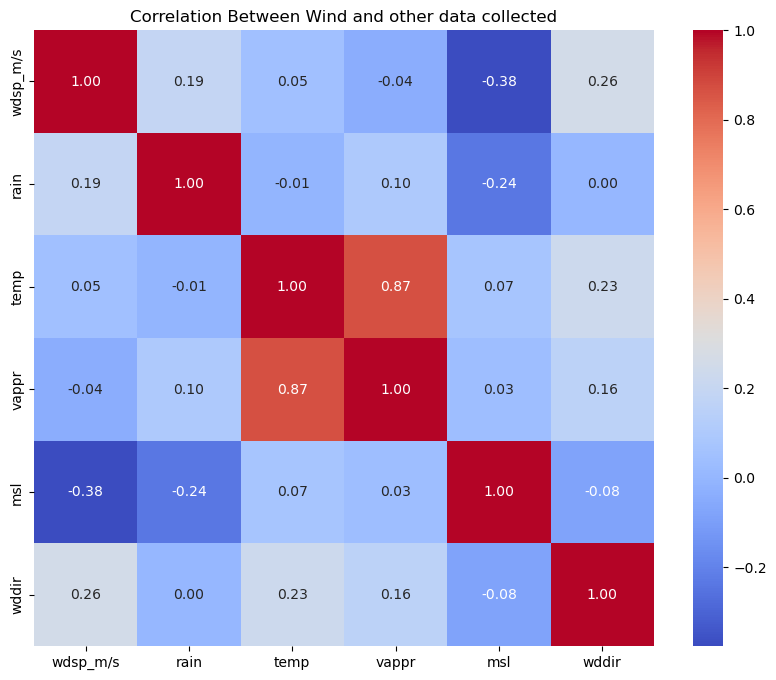

In [56]:
# Selecting columns to for correlation analysis between wind and other information we have.
selected_columns = ['wdsp_m/s', 'rain', 'temp', 'vappr', 'msl', 'wddir']
correlation_df = df_wind_project[selected_columns]

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Between Wind and other data collected')
plt.show()

### Deciding on which data to keep:

As we can see from the above, there is no direct connection between wind speed and the other data we currently have. 

In the next section, I will:

1. **Calculate the air density** and add it as a new column. The required data for this calculation includes:
   - Temperature (`temp`)
   - Vapour pressure (`vappr`)
   - Mean sea level pressure (`msl`)

2. **Calculate the power output** and add it as a new column. The required data for this calculation includes:
   - Air density (`air_density`)
   - Wind speed (`wdsp_m/s`)
   - Rotor swept area - calculated for a common wind turbine size with a diameter of 100 meters.
   - Power coefficient - typically ranging between 0.3 and 0.5. For this analysis, I used a value of 0.4.

3. **Remove unnecessary columns**, including:
   - Wind direction (`wddir`): While wind direction is crucial for energy output, modern wind turbines address this factor automatically. Their blades adjust dynamically to optimize wind capture regardless of direction, making this data redundant for my calculations.

**Important**

_To make my code more efficient, I'm using a single function, `add_new_column`, to handle both air density and power energy calculations. The function determines which calculating function based on the parameters passed and adds the appropriate new column to the dataset._
***

### Calculating Air Density

To calculate the air density using the data available in my dataset I used the general air density formula derived from the _Ideal Gas Law_ for both dry air and water vapor: 

$$
\rho = \frac{p_d}{R_d T} + \frac{p_v}{R_v T}
$$

Where:

- $ \rho $: Air density in $ \text{kg/m}^3 $
- $ p_d $: Dry air pressure, calculated as $ p_d = \text{msl} - \text{vappr} $ (Pa)
- $ p_v $: Vapor pressure ($ \text{vappr} $) in Pascals (Pa)
- $ T $: Temperature in Kelvin (K), converted as:

  $$
  T_{\text{Kelvin}} = T_{\text{Celsius}} + 273.15
  $$

- $ R_d $: Specific gas constant for dry air (287.05 J/(kg·K))
- $ R_v $: Specific gas constant for water vapor (461.5 J/(kg·K))


Functions used:
- `calculate_air_density`
- `add_new_column`

In [57]:
# Making changes to the dataset by adding a new column
df_wind_project = add_new_column(df_wind_project, column='air_density')
# Checking if it works
df_wind_project.head(5)

,rain,wddir,wdsp_m/s,air_density
date,,,,
1945-01-01 00:00:00,0.0,350.0,1.54,1.275812
1945-01-01 01:00:00,0.0,360.0,1.03,1.277857
1945-01-01 02:00:00,0.0,10.0,3.09,1.276715
1945-01-01 03:00:00,0.0,350.0,4.63,1.276509
1945-01-01 04:00:00,0.0,350.0,4.63,1.274731


In [58]:
# Checking the air density values: range, mean, std etc...
# Get summary statistics for the column
df_wind_project['air_density'].describe()

count    701104.000000
mean          1.238742
std           0.023298
min           1.149262
25%           1.222173
50%           1.236371
75%           1.253356
max           1.347003
Name: air_density, dtype: float64

***
### Calculating energy power

The Sustainable Energy Authority of Ireland (SEAI) notes that wind turbines with rotor diameters of 100 meters or more and hub heights exceeding 100 meters have become increasingly common in recent years. In this project, I will focus on calculating the potential energy production to simulate the scenario of placing a turbine in a specific location. Using the specifications of the Senvion MM100 wind turbine model [Senvion MM100](https://en.wind-turbine-models.com/turbines/890-senvion-mm100?utm_source=chatgpt.com)—featuring a rotor diameter of 100 meters and a Power Coefficient (efficiency) of 0.4.

**_I will estimate how much energy could have been generated if such a turbine were installed there. This exercise is centered on understanding the potential power output, not actual operational data._**

The wind power equation is expressed as follows:

$$
P = 0.5 \times \rho \times A \times V^3 \times E
$$

Where:
- **P** = Power in Watts  
- **$\rho$** = Air Density in kg/m³ (about 1.225 kg/m³ at sea level, decreases with altitude)  
- **A** = Rotor Swept Area in m² = $\pi r^2$ (where $r$ = radius or blade length)  
- **V** = Wind Speed in m/s (cubed)  
- **E** = Efficiency (Power Coefficient, typically between 0.3 and 0.5)

Functions used:
- `calculate_power_for_row`
- `add_new_column`

In [59]:
# Making changes to the dataset by adding a new column 'power_output' 
df_wind_project = add_new_column(df_wind_project, column='power_kw')
# Checking if it works
df_wind_project.head(5)

,rain,wdsp_m/s,air_density,power_kw
date,,,,
1945-01-01 00:00:00,0.0,1.54,1.275812,0.00
1945-01-01 01:00:00,0.0,1.03,1.277857,0.00
1945-01-01 02:00:00,0.0,3.09,1.276715,59.17
1945-01-01 03:00:00,0.0,4.63,1.276509,199.02
1945-01-01 04:00:00,0.0,4.63,1.274731,198.74


***
### Checking the Correlation between the remaining data in df_wind_project 

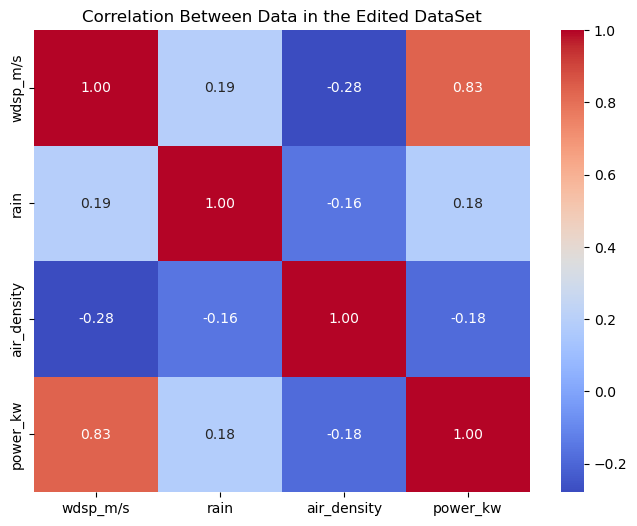

In [60]:
# Selecting columns to for correlation between the data in the df_wind_project DataFrame
selected_columns = ['wdsp_m/s', 'rain', 'air_density', 'power_kw' ]
correlation_df = df_wind_project[selected_columns]

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Between Data in the Edited DataSet')
plt.show()

### Dropping another column `rain`

From the heatmap above, it is evident that the rain column has no correlation with the other columns in the DataFrame. Therefore, I have decided to remove it from the DataFrame.

In [61]:
# Drop 'rain' and display just the 3 first rows to check the code worked.
df_wind_project.drop(columns='rain').head(3)

,wdsp_m/s,air_density,power_kw
date,,,
1945-01-01 00:00:00,1.54,1.275812,0.00
1945-01-01 01:00:00,1.03,1.277857,0.00
1945-01-01 02:00:00,3.09,1.276715,59.17


***
## Part 3 - Operational Range Analysis.
***

### Calculation how many hours per day the wind speed is between 3m/s(cut-in speed for the turbines to start working) to 22m/s(cut-out speed).

In the next code section I am checking if the wind speed (`wdsp_m/s`) in my DataFrame (df_wind_project) is within the range [3, 22] and creating a new Boolean column, `in_range`, to show if the condition is met (`True` or `False`). Next the code is converting these Boolean values into integers (`1` for `True` and `0` for `False`) and stores them in another column, `hours_in_range`, which we can use for analysis later on.

_If the wind speed is not in the range the value of `power_kw` will be `0`_

To make code more efficient I updated the `add_new_column` function for this step.

In [62]:
df_wind_project = add_new_column(df_wind_project, 'in_range')
df_wind_project = add_new_column(df_wind_project, 'hours_in_range')
df_wind_project.head()

,rain,wdsp_m/s,air_density,power_kw,in_range,hours_in_range
date,,,,,,
1945-01-01 00:00:00,0.0,1.54,1.275812,0.00,False,0
1945-01-01 01:00:00,0.0,1.03,1.277857,0.00,False,0
1945-01-01 02:00:00,0.0,3.09,1.276715,59.17,False,0
1945-01-01 03:00:00,0.0,4.63,1.276509,199.02,True,1
1945-01-01 04:00:00,0.0,4.63,1.274731,198.74,True,1


### Using .describe command to get statistics about data in the dataset and I will graph the results:

In [63]:
summary_stats = df_wind_project[['wdsp_m/s', 'air_density', 'power_kw']].describe()
summary_stats

,wdsp_m/s,air_density,power_kw
count,701104.000000,701104.000000,701104.000000
mean,5.203486,1.238742,604.471315
std,3.146793,0.023298,1050.608644
min,0.000000,1.149262,0.000000
25%,3.090000,1.222173,56.310000
50%,5.140000,1.236371,257.250000
75%,7.200000,1.253356,719.450000
max,29.840000,1.347003,19499.320000


### Plotting summary statistics with log scale for y-axis

The _power output_ value is too big comparing to other data in the dataset so I am using log scale measuring for y-axis.

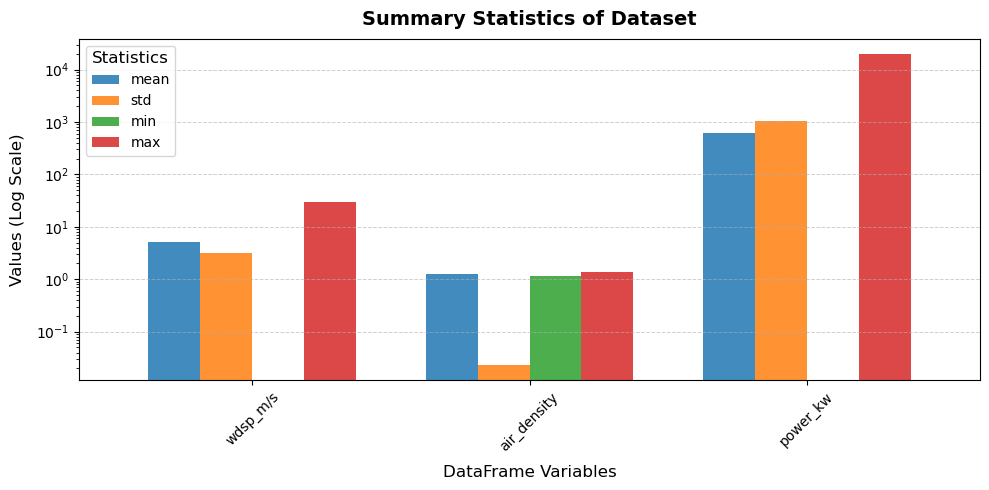

In [64]:
# Transpose for easier plotting (columns become rows)
summary_stats = summary_stats.transpose()

# Set up the figure and axes with smaller size
fig, ax = plt.subplots(figsize=(10, 5))  # Setting up the size of my graph.

# Plotting the bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Setting up the colors.
summary_stats[['mean', 'std', 'min', 'max']].plot(
    kind='bar',
    ax=ax,
    width=0.75,
    alpha=0.85,
    color=colors
)
# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Adding labels and title
ax.set_title('Summary Statistics of Dataset', fontsize=14, fontweight='bold', pad=10)
ax.set_ylabel('Values (Log Scale)', fontsize=12, labelpad=8)
ax.set_xlabel('DataFrame Variables', fontsize=12, labelpad=8)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Customizing gridlines
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Adjusting the legend
ax.legend(title='Statistics', fontsize=10, title_fontsize=12, loc='upper left')

# Add tight layout for better spacing and Show the plot.
plt.tight_layout()
plt.show()

***
## Part 4 - Seasonal Analysis.
***

In [65]:
# Extract additional time-based features from the index (date is set as DataFrame index)
df_wind_project = df_wind_project.copy()
df_wind_project.loc[:, 'year'] = df_wind_project.index.year                     # Extract year.
df_wind_project.loc[:, 'month'] = df_wind_project.index.month                   # Extract month.

In [66]:
# Creating a new column 'season_label' in the DataFrame referring to 'month' 
# by calling 'get_season' function in the 'project_functions.py' file.
df_wind_project['season_label'] = df_wind_project['month'].apply(get_season)

# Group data by season and calculate averages for our numerical data.
seasonal_averages = df_wind_project.groupby('season_label').mean()

# Print the 'mean' values of our numeric data.
print(seasonal_averages[['wdsp_m/s', 'air_density', 'power_kw']])

              wdsp_m/s  air_density    power_kw
season_label                                   
Autumn        4.767695     1.225643  457.502177
Spring        5.545879     1.251312  716.240889
Summer        4.538001     1.229646  367.442194
Winter        5.972554     1.248745  880.021512


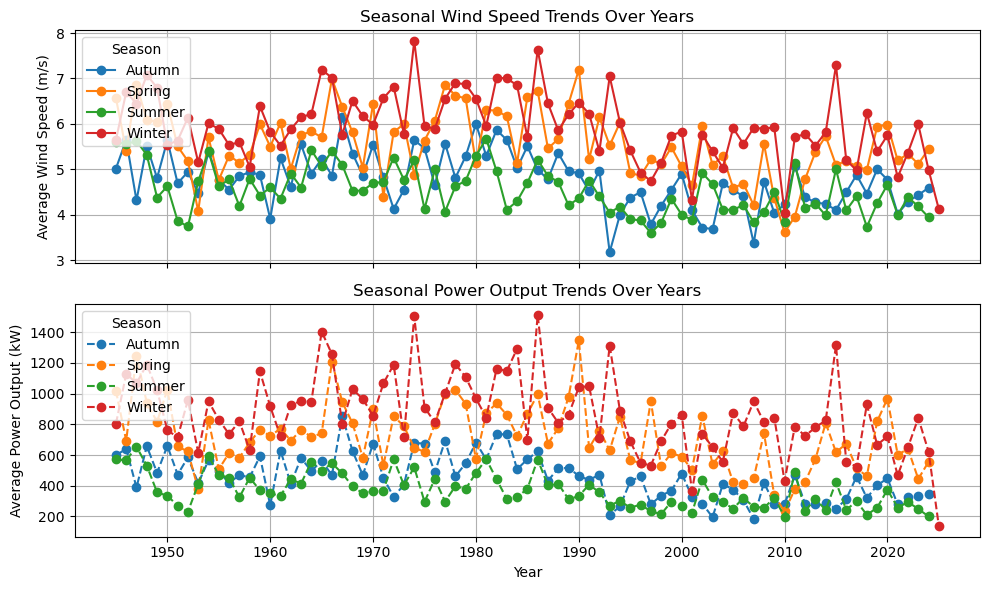

In [67]:
# Grouping wind speed and power output by season and year
seasonal_trends_wdsp = df_wind_project.groupby(['year', 'season_label'])['wdsp_m/s'].mean().unstack()
seasonal_trends_power = df_wind_project.groupby(['year', 'season_label'])['power_kw'].mean().unstack()
# Creating a figure with two subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plotting wind speed trends in the first subplot
axes[0].plot(seasonal_trends_wdsp, marker='o')
axes[0].set_title('Seasonal Wind Speed Trends Over Years')
axes[0].set_ylabel('Average Wind Speed (m/s)')
axes[0].legend(seasonal_trends_wdsp.columns, title='Season', loc='upper left')
axes[0].grid()

# Plotting power output trends in the second subplot
axes[1].plot(seasonal_trends_power, marker='o', linestyle='--')
axes[1].set_title('Seasonal Power Output Trends Over Years')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Power Output (kW)')
axes[1].legend(seasonal_trends_power.columns, title='Season', loc='upper left')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Percentage of Wind Speed and Power Output by Season and Year

In this section I am calculating the above values to percentages by season and year and showing them graphically.

In [68]:
# Calculating the total wind speed for each year
total_wdsp_by_year = seasonal_trends_wdsp.sum(axis=1)

# Calculating the percentage of power production for each season
percentage_wind_by_season = seasonal_trends_wdsp.div(total_wdsp_by_year, axis=0) * 100

# Calculating the total power production for each year
total_power_by_year = seasonal_trends_power.sum(axis=1)

# Calculating the percentage of power production for each season
percentage_power_by_season = seasonal_trends_power.div(total_power_by_year, axis=0) * 100

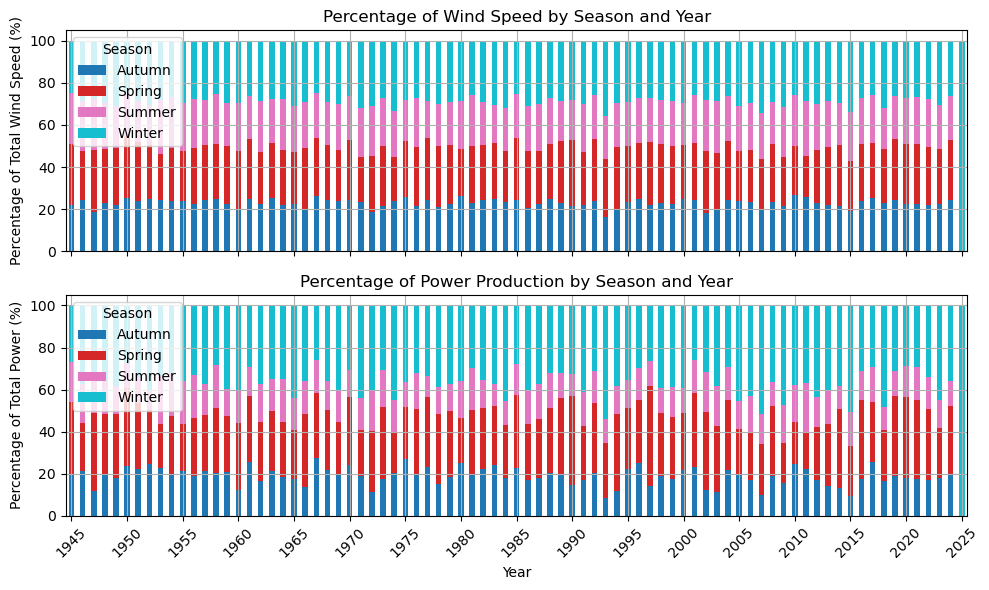

In [69]:
# Creating a figure with two subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plotting the wind speed percentage data in the first subplot
percentage_wind_by_season.plot(kind='bar', stacked=True, ax=axes[0], cmap='tab10')
axes[0].set_title('Percentage of Wind Speed by Season and Year')
axes[0].set_ylabel('Percentage of Total Wind Speed (%)')
axes[0].legend(title='Season')
axes[0].grid(True)

# Plotting the power production percentage data in the second subplot
percentage_power_by_season.plot(kind='bar', stacked=True, ax=axes[1], cmap='tab10')
axes[1].set_title('Percentage of Power Production by Season and Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage of Total Power (%)')
axes[1].legend(title='Season')
axes[1].grid(True)

# Setting x-axis to display every 5th year on both plots
years = percentage_power_by_season.index
tick_positions = range(0, len(years), 5)  # Every 5th year
tick_labels = years[tick_positions]  # Corresponding year labels

# Setting x-axis, ticks and labels for both subplots
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels, rotation=45)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels, rotation=45)

# Adjusting layout for better spacing and show the plot
plt.tight_layout()
plt.show()

### Percentages as a Pie Chart

The pie chart shows the percentage of total wind speeds and energy output for each season. I added exploded slices and a shadow to make it look better and highlight the data. This helps easily see which seasons has the highest wind speeds and produce the most energy in a simple and clear way. I am using a side by side chart.

In [70]:
# Calculating the average percentage of wind speed of each season.
average_percentage_wdsp_by_season = percentage_wind_by_season.mean()

# Calculating the average percentage of power output of each season.
average_percentage_power_by_season = percentage_power_by_season.mean()

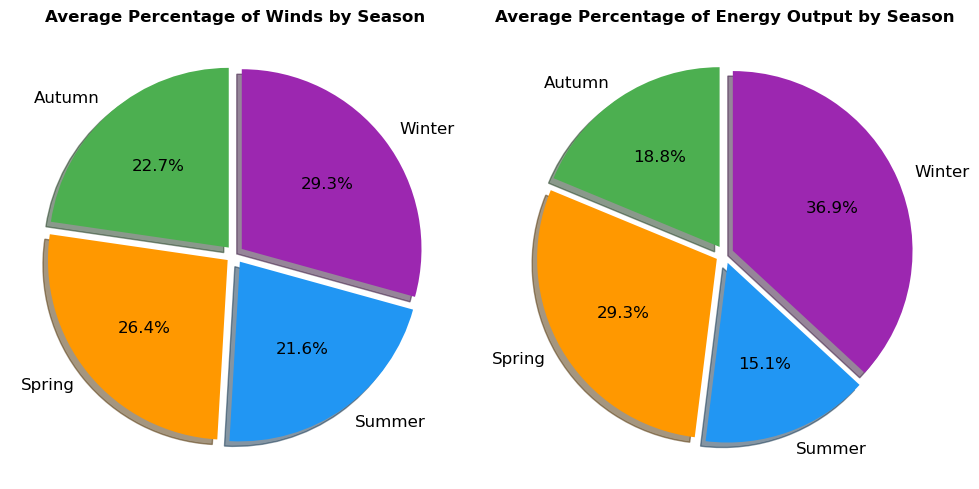

In [71]:
# Creating the pie chart.
# Setting the color palette and explode values.
colors = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']
explode_power = [0.05] * len(average_percentage_power_by_season)
explode_wind = [0.05] * len(average_percentage_wdsp_by_season)

# Creating a figure with 1 row and 2 columns and setting the figure size.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# Pie chart for wind speed percentages
axes[0].pie(
    average_percentage_wdsp_by_season,
    labels=average_percentage_wdsp_by_season.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode_wind,
    shadow=True,
    textprops={'fontsize': 12}
)
axes[0].set_title('Average Percentage of Winds by Season', fontsize=12, weight='bold')

# Pie chart for energy output percentages
axes[1].pie(
    average_percentage_power_by_season,
    labels=average_percentage_power_by_season.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode_power,
    shadow=True,
    textprops={'fontsize': 12}
)
axes[1].set_title('Average Percentage of Energy Output by Season', fontsize=12, weight='bold')

# Adjust layout and spacing
plt.tight_layout()
plt.show()

### Results: 

- Winter has the highest wind speed and power output, making it the most important season for energy production.
- Spring also contributes significantly, especially to wind speed and power output.
- Autumn and Summer have lower contributions compared to Winter and Spring, with Summer having the smallest share in both wind speed and power output.

***
## Part 5 - Trend Analysis & more.
***

***

### Analyzing Data Using the `.random.choice()` Command

In this section, I will randomly pick a few days of data and compare the wind speed levels on these days. The goal is to learn more from this small set of data and find any patterns or trends.

***

In [72]:
# Randomly choose 5 unique days from the dataset's index
random_seasonal_days = np.random.choice(df_wind_project.index.normalize().unique(), size=5, replace=False)

# Converting numpy.datetime64 to pandas.Timestamp and format the dates for easier reading.
formatted_random_dates = [pd.Timestamp(date).strftime('%d-%m-%Y') for date in random_seasonal_days]
formatted_random_dates      # display the dates formatted. 

['05-05-1992', '18-11-1984', '14-04-2002', '14-06-2010', '20-01-2016']

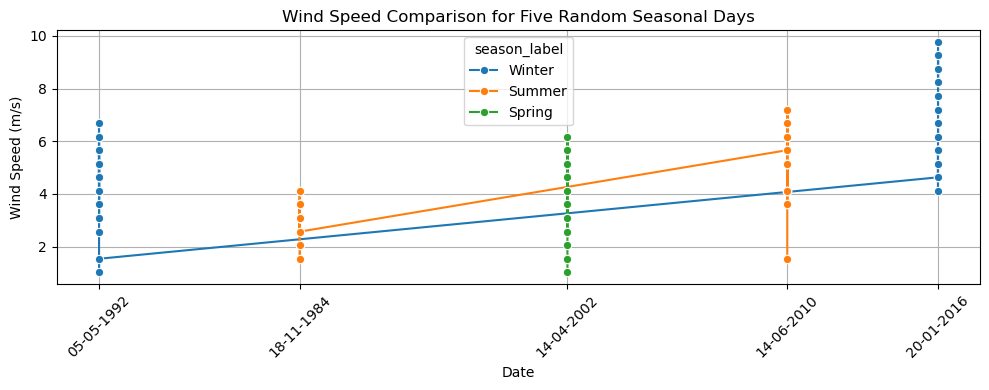

In [73]:
# Filtering the dataset for the random seasonal days got from the previous code.
random_seasonal_data = df_wind_project[df_wind_project.index.normalize().isin(random_seasonal_days)]

# Plotting table.
plt.figure(figsize=(10, 4))

# Plotting the wind speed with the formatted dates on the x-axis, wind speed in the
sns.lineplot(x=random_seasonal_data.index, y=random_seasonal_data['wdsp_m/s'], hue=random_seasonal_data['season_label'], marker='o')

# Setting plot titles and labels
plt.title('Wind Speed Comparison for Five Random Seasonal Days')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')

# Set the x-axis labels to the formatted random dates, matching the actual date points
plt.xticks(ticks=random_seasonal_data.index.normalize().unique(), labels=formatted_random_dates, rotation=45)

# Show gridlines for better visibility
plt.grid(True)

# Tight layout & show.
plt.tight_layout()
plt.show()

***
### Yearly data with a trend line over the past 20 years - Wind Speed & Power Output.

This code analyzes wind speed and power output data from the past 20 years (2004–2024). It first extracts the year from the dataset and filters the data to include only this time period. For wind speed, it calculates the total hours where the speed falls within a specific range (e.g., between the turbine's cut-in and cut-out speeds) for each year. A similar process is applied to power output data, grouping it by year to calculate yearly totals or averages.

The code performs separate linear regressions on both wind speed and power output to identify potential trends over time. It computes key regression statistics such as the slope (rate of change per year), the R-squared value (indicating how well the trend explains the data), and the minimum and maximum values over the period.

Finally, the code generates plots for the yearly wind speed and power output data, overlaying trend lines derived from the regression analysis to visually represent changes over the years

***

In [74]:
# Extracting year for grouping
df_wind_project['year'] = df_wind_project.index.year

# Filtering data for the past 20 years (2004–2024)
df_last_20_years = df_wind_project.loc['2004-01-01':'2024-12-31']

# Grouping by year to calculate yearly wind speed in the range (how many hours/year).
yearly_wind_data_20_years = df_last_20_years.groupby('year')['hours_in_range'].sum()

# Perform linear regression for the last 20 years
years = yearly_wind_data_20_years.index
slope, intercept, r_value, p_value, std_err = linregress(years, yearly_wind_data_20_years.values)

# Print regression details
print("Wind Speed Regression details:")
print(f"Linear Trend (2004-2024): Slope = {slope:.2f} hours/year, Intercept = {intercept:.2f}")
print(f"R-squared = {r_value**2:.2f}, p-value = {p_value:.2e}")
print(f"Minimum hours within the range per Year: {yearly_wind_data_20_years.min()}")
print(f"Maximum hours within the range per Year: {yearly_wind_data_20_years.max()}")

Wind Speed Regression details:
Linear Trend (2004-2024): Slope = 18.24 hours/year, Intercept = -31587.44
R-squared = 0.09, p-value = 1.85e-01
Minimum hours within the range per Year: 4120
Maximum hours within the range per Year: 5608


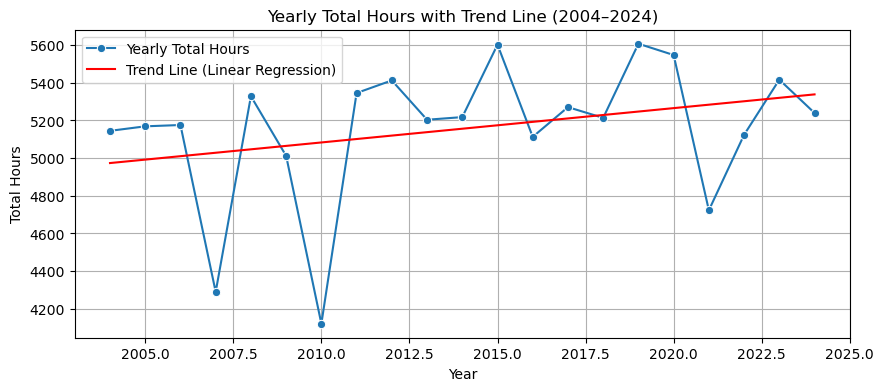

In [75]:
# Plot with regression line for the last 20 years
plt.figure(figsize=(10, 4))
sns.lineplot(x=yearly_wind_data_20_years.index, y=yearly_wind_data_20_years.values, marker='o', label='Yearly Total Hours')
plt.plot(years, intercept + slope * years, 'r-', label='Trend Line (Linear Regression)')
plt.title('Yearly Total Hours with Trend Line (2004–2024)')
plt.xlabel('Year')
plt.ylabel('Total Hours')
plt.grid(True)
plt.legend()
plt.show()

In [76]:
# Grouping by year to calculate yearly power in the range (how many hours/year).
yearly_power_data_20_years = df_last_20_years.groupby('year')['power_kw'].sum()

# Perform linear regression for the last 20 years
years_power = yearly_power_data_20_years.index
slope, intercept, r_value, p_value, std_err = linregress(years_power, yearly_power_data_20_years.values)

# Print regression details
print("Power Output Regression details:")
print(f"Linear Trend (2004-2024): Slope = {slope:.2f} power/year, Intercept = {intercept:.2f}")
print(f"R-squared = {r_value**2:.2f}, p-value = {p_value:.2e}")
print(f"Minimum power output per Year: {yearly_power_data_20_years.min()}kw")
print(f"Maximum power output per Year: {yearly_power_data_20_years.max()}kw")

Power Output Regression details:
Linear Trend (2004-2024): Slope = 9107.80 power/year, Intercept = -14135845.28
R-squared = 0.01, p-value = 7.21e-01
Minimum power output per Year: 2497170.24kw
Maximum power output per Year: 5680813.53kw


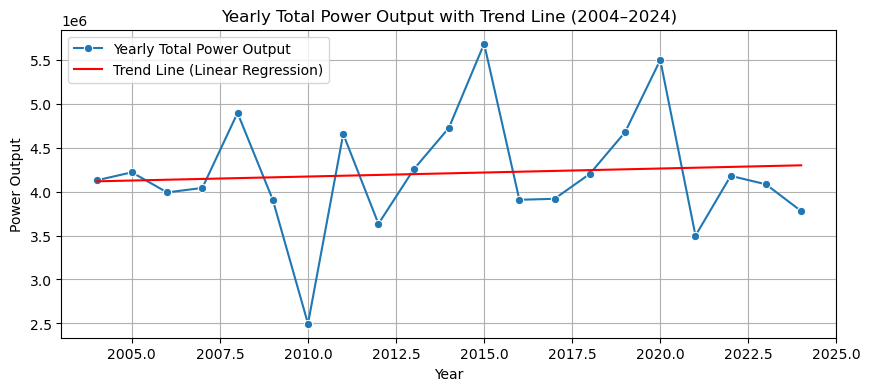

In [77]:
# Plot with regression line for the last 20 years
plt.figure(figsize=(10, 4))
sns.lineplot(x=yearly_power_data_20_years.index, y=yearly_power_data_20_years.values, marker='o', label='Yearly Total Power Output')
plt.plot(years_power, intercept + slope * years_power, 'r-', label='Trend Line (Linear Regression)')
plt.title('Yearly Total Power Output with Trend Line (2004–2024)')
plt.xlabel('Year')
plt.ylabel('Power Output')
plt.grid(True)
plt.legend()
plt.show()

### <u>Results</u>

**Wind Speed**

The analysis of yearly wind hours for the period 2004–2024 reveals a linear trend with a slope of 18.24 hours per year, indicating a modest annual increase in the number of hours with optimal wind speeds. The intercept provides context for the regression line but has limited practical significance. The R-squared value suggests a weak correlation between the trend and the yearly data, meaning other factors likely influence the variability. A p-value indicates that the trend is not statistically significant at typical confidence levels (e.g., 95%). 

_However_, the yearly wind hours fall within the optimal range, showing that the wind turbine can have consistently operated within desirable limits over the analyzed period. This consistency in achieving optimal hours is encouraging for a farm's performance (if build one in the area), despite the weak trend.

**Power Ouput**

The analysis of yearly power output from 2004–2024 shows a modest linear trend, indicating a slight annual increase. 

Despite the weak trend, the yearly power output remains consistent. This stability underscores the wind turbines' reliable performance over the analyzed period.

***
## Last Part - Predictions.
***

### Prediction of Wind Speed and Power Output for the next 5 years using Linear Regression Method
***

In this section I am looking again at data from the last 20 years (2004-2024) to calculate the total yearly power output and wind speed (in hours within a certain range) for each year. After using linear regression I am trying to find the trend of both power output and wind speed over the years. The code calculates key values like slope, intercept, and R-squared to show how strongly the data is related (I did the same thing in the previous section). After that, it predicts the power output and wind speed for the next five years (2025-2029) based on these trends. Finally, it prints the predicted values for each year, helping to understand future performance.

In [78]:
# Grouping by year to calculate yearly power and wind speed (in range)
yearly_power_data_20_years = df_last_20_years.groupby('year')['power_kw'].sum()
yearly_wind_data_20_years = df_last_20_years.groupby('year')['hours_in_range'].sum()

# Perform linear regression for the last 20 years for power
years_power = yearly_power_data_20_years.index
slope_power, intercept_power, r_value_power, p_value_power, std_err_power = linregress(years_power, yearly_power_data_20_years.values)

# Perform linear regression for the last 20 years for wind speed (hours in range)
years_wind_speed = yearly_wind_data_20_years.index
slope_wind_speed, intercept_wind_speed, r_value_wind_speed, p_value_wind_speed, std_err_wind_speed = linregress(years_wind_speed, yearly_wind_data_20_years.values)

# Predict for the next 5 years (2025-2029) for both power and wind speed
next_years = np.array([2025, 2026, 2027, 2028, 2029])

# Linear regression prediction formula: y = slope * x + intercept
predicted_power = slope_power * next_years + intercept_power
predicted_wind_speed = slope_wind_speed * next_years + intercept_wind_speed

# Print the predicted values for the next years
print("\nPredicted Power Output for the next 5 years:")
for year, power in zip(next_years, predicted_power):
    print(f"Year: {year} - Predicted Power Output: {power:.2f} kW")

print("\nPredicted Wind Speed (Hours in Range) for the next 5 years:")
for year, wind_speed in zip(next_years, predicted_wind_speed):
    print(f"Year: {year} - Predicted Wind Speed: {wind_speed:.2f} hours")


Predicted Power Output for the next 5 years:
Year: 2025 - Predicted Power Output: 4307442.67 kW
Year: 2026 - Predicted Power Output: 4316550.47 kW
Year: 2027 - Predicted Power Output: 4325658.26 kW
Year: 2028 - Predicted Power Output: 4334766.06 kW
Year: 2029 - Predicted Power Output: 4343873.86 kW

Predicted Wind Speed (Hours in Range) for the next 5 years:
Year: 2025 - Predicted Wind Speed: 5356.97 hours
Year: 2026 - Predicted Wind Speed: 5375.22 hours
Year: 2027 - Predicted Wind Speed: 5393.46 hours
Year: 2028 - Predicted Wind Speed: 5411.70 hours
Year: 2029 - Predicted Wind Speed: 5429.95 hours


### Plotting the Results:

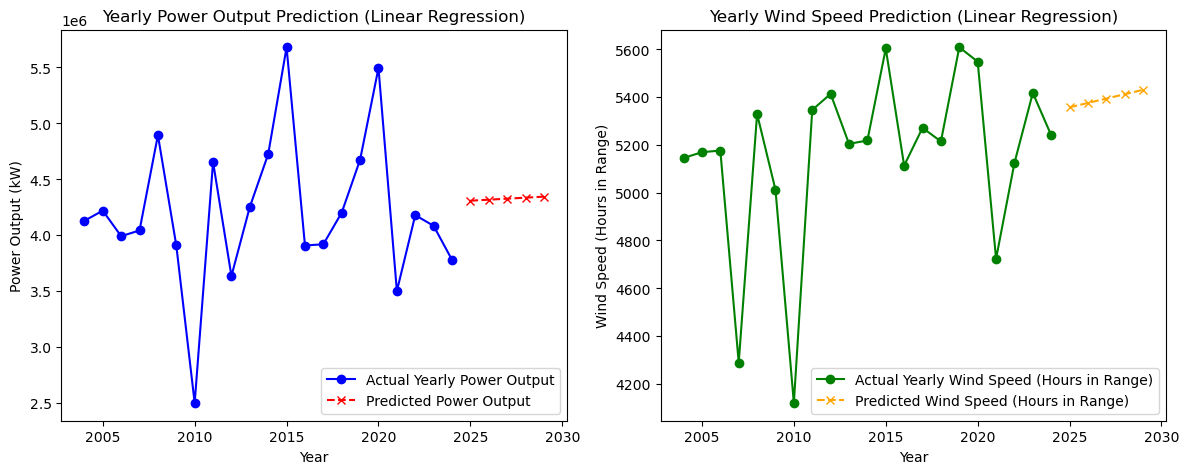

In [79]:
# Plotting the predictions and the linear regression lines
plt.figure(figsize=(12, 5))

# Plotting the actual data (yearly power output) as a line plot
plt.subplot(1, 2, 1)
plt.plot(years_power, yearly_power_data_20_years.values, label='Actual Yearly Power Output', color='blue', marker='o')
plt.plot(next_years, predicted_power, label='Predicted Power Output', color='red', linestyle='--', marker='x')
plt.title('Yearly Power Output Prediction (Linear Regression)')
plt.xlabel('Year')
plt.ylabel('Power Output (kW)')
plt.legend()

# Plotting the actual data (yearly wind speed) as a line plot
plt.subplot(1, 2, 2)
plt.plot(years_wind_speed, yearly_wind_data_20_years.values, label='Actual Yearly Wind Speed (Hours in Range)', color='green', marker='o')
plt.plot(next_years, predicted_wind_speed, label='Predicted Wind Speed (Hours in Range)', color='orange', linestyle='--', marker='x')
plt.title('Yearly Wind Speed Prediction (Linear Regression)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (Hours in Range)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

***
## Predictions for the next Spring season using SARIMA models
***

SARIMA (Seasonal AutoRegressive Integrated Moving Average) models are an extension of the ARIMA model, designed to handle time series data with seasonality. SARIMA incorporates both non-seasonal and seasonal components, making it ideal for data with periodic patterns. It consists of three main parameters for non-seasonal components (p, d, q) and three for seasonal components (P, D, Q, m), where 'm' represents the length of the seasonal cycle. SARIMA models are widely used in forecasting tasks, as they can capture trends, seasonal variations, and irregular fluctuations in time series data.

The code is designed to forecast wind speed and power generation for the upcoming spring (March, April, May) based on the last **_10 years_** of historical data. It begins by selecting relevant data from the `df_last_20_years` dataset, handling any missing or infinite values, and then filtering for "Spring" season data. After resampling this data to daily averages, it fits SARIMA models to both power generation and wind speed, accounting for seasonal patterns. Finally, the code forecasts the next 92 days of spring and displays the results, helping to predict wind conditions and power generation for the upcoming season.
***

In [80]:
# Working with a copy of df_last_20_years containing only wind speed, power and season.
data = df_last_20_years[['wdsp_m/s', 'power_kw', 'season_label']].copy()

# Making sure there is no infinite values.
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check the first few rows of the data to ensure the season column is correct
print("Sample of the data with season labels:")
print(data.head(3))

# Filtering the DataFrame for spring data from the last 10 years
last_10_springs = data[(data['season_label'] == 'Spring') & (data.index.year >= data.index.year.max() - 9)]

# Check if we have any data for the last 10 springs
print(f"Number of data points in the last 10 springs: {len(last_10_springs)}")

# If the dataset is empty, print out additional information
if len(last_10_springs) == 0:
    print("No data found for the last 10 springs. Please check your date range and season filtering.")

# Exclude the 'season_label' column and resample to daily mean data
daily_spring_data = last_10_springs.drop(columns=['season_label']).resample('D').mean()

# Check if the daily_spring_data is empty
print(f"Number of daily data points: {len(daily_spring_data)}")

# If the dataset is empty, print a message and stop further execution
if len(daily_spring_data) == 0:
    print("No daily data available after resampling. Exiting the model.")
else:
    # Separate power and wind datasets
    power_data = daily_spring_data['power_kw']
    wind_data = daily_spring_data['wdsp_m/s']

    # Defining SARIMA parameters (Adjust based on analysis)
    p, d, q = 1, 0, 1  # Non-seasonal ARIMA parameters
    P, D, Q, m = 1, 0, 1, 7  # Seasonal parameters with weekly seasonality (m=7 for daily data)

    # Fit SARIMA model for power data
    power_model = SARIMAX(power_data, 
                          order=(p, d, q), 
                          seasonal_order=(P, D, Q, m),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
    power_model_fit = power_model.fit(disp=False)

    # Fit SARIMA model for wind data
    wind_model = SARIMAX(wind_data, 
                         order=(p, d, q), 
                         seasonal_order=(P, D, Q, m),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    wind_model_fit = wind_model.fit(disp=False)

    # Forecast for the next spring (92 days for March, April, May)
    forecast_steps = 92  # Number of days in spring (March, April, May)
    power_forecast = power_model_fit.forecast(steps=forecast_steps)
    wind_forecast = wind_model_fit.forecast(steps=forecast_steps)

    # Combine results and display
    forecast_dates = pd.date_range(start='2025-03-01', periods=forecast_steps, freq='D')
    forecast_df = pd.DataFrame({'date': forecast_dates, 
                                'power_forecast': power_forecast, 
                                'wind_forecast': wind_forecast})

    print("Forecast for Spring 2025:")
    print(forecast_df)


Sample of the data with season labels:
                     wdsp_m/s  power_kw season_label
date                                                
2004-01-01 00:00:00      8.23   1085.93       Winter
2004-01-01 01:00:00      9.26   1546.45       Winter
2004-01-01 02:00:00      9.26   1547.35       Winter
Number of data points in the last 10 springs: 21407
Number of daily data points: 3377
Forecast for Spring 2025:
                 date  power_forecast  wind_forecast
2024-05-01 2025-03-01      205.778242       2.908363
2024-05-02 2025-03-02      260.416040       2.776563
2024-05-03 2025-03-03      378.341089       2.715803
2024-05-04 2025-03-04      457.401172       2.633213
2024-05-05 2025-03-05      445.079862       2.550345
...               ...             ...            ...
2024-07-27 2025-05-27      500.077446       0.289006
2024-07-28 2025-05-28      468.084902       0.281405
2024-07-29 2025-05-29      501.903930       0.273945
2024-07-30 2025-05-30      439.422355       0.266862
2

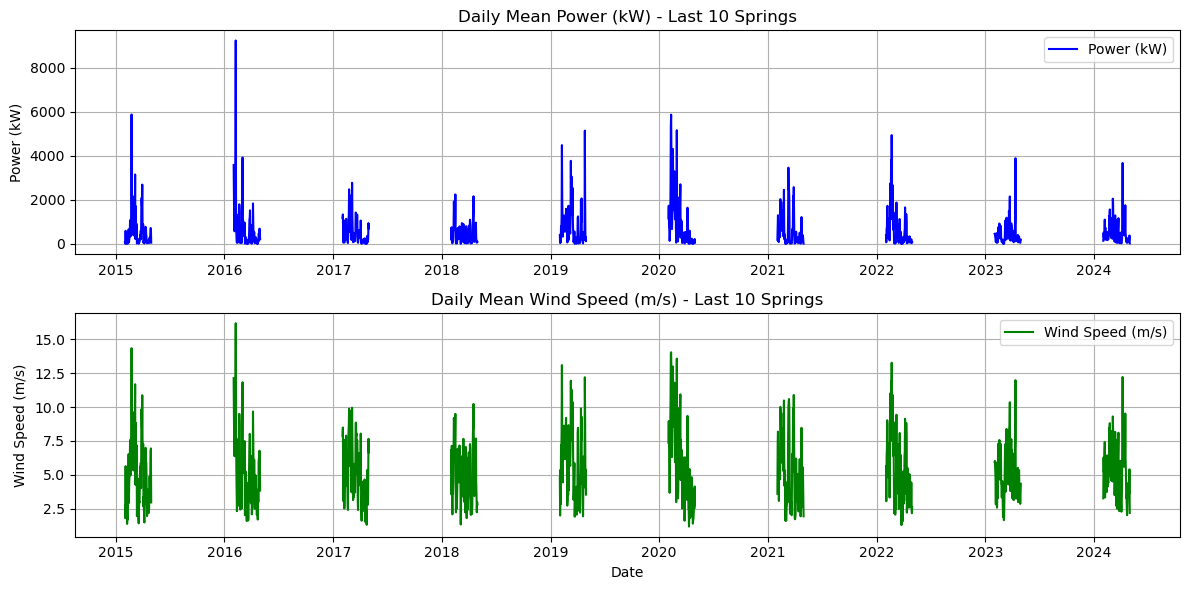

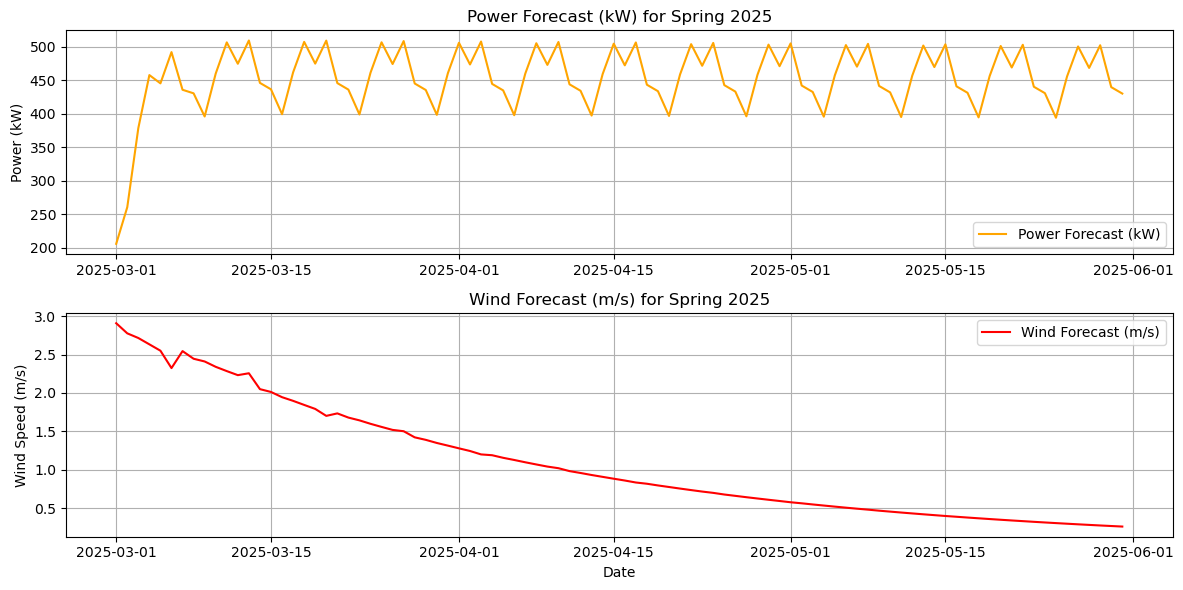

In [81]:
# Plotting daily spring data
if len(daily_spring_data) > 0:
    plt.figure(figsize=(12, 6))

    # Plot power data
    plt.subplot(2, 1, 1)
    plt.plot(daily_spring_data.index, daily_spring_data['power_kw'], label='Power (kW)', color='blue')
    plt.title('Daily Mean Power (kW) - Last 10 Springs')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid()

    # Plot wind speed data
    plt.subplot(2, 1, 2)
    plt.plot(daily_spring_data.index, daily_spring_data['wdsp_m/s'], label='Wind Speed (m/s)', color='green')
    plt.title('Daily Mean Wind Speed (m/s) - Last 10 Springs')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (m/s)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plotting forecasted data
if not forecast_df.empty:
    plt.figure(figsize=(12, 6))

    # Plot power forecast
    plt.subplot(2, 1, 1)
    plt.plot(forecast_df['date'], forecast_df['power_forecast'], label='Power Forecast (kW)', color='orange')
    plt.title('Power Forecast (kW) for Spring 2025')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid()

    # Plot wind forecast
    plt.subplot(2, 1, 2)
    plt.plot(forecast_df['date'], forecast_df['wind_forecast'], label='Wind Forecast (m/s)', color='red')
    plt.title('Wind Forecast (m/s) for Spring 2025')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (m/s)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


***
### _End_